In [1]:
import gym
import json
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm
import time


from gym.envs.toy_text.frozen_lake import generate_random_map


## Environment setting

In [2]:
attempt_1 = ['SFFF', 'FHHF', 'FFHF', 'FHHG']

In [3]:
random.seed(42)

In [4]:
new_map = generate_random_map(size=4, p = 0.6)

In [5]:
if attempt_1:
    env = gym.make('FrozenLake-v1', desc=attempt_1, render_mode = 'human')
else:
    env = gym.make('FrozenLake-v1', desc=new_map, render_mode = 'human')
    

In [6]:
a, prob = env.reset()

## Random attempt

In [17]:
def random_walk(episodes, max_steps_to_failure):
    outcomes = []
    steps_taken = []
    
    for episode in tqdm.tqdm(range(episodes)):
        state = env.reset()
        done = False
        outcomes.append('Failure')
        step = 0
        while not done:
            env.render()
            action = env.action_space.sample()
            step+=1
            new_state, reward, done, info, prob = env.step(action)
            state = new_state
            if reward:
                outcomes[-1] = 'Success'
            if step == max_steps_to_failure:
                done = True

        steps_taken.append(step)
    
    return outcomes, steps_taken

In [20]:
outcomes, steps_taken = random_walk(5000, 50)

100%|██████████| 5000/5000 [6:17:41<00:00,  4.53s/it]  


In [7]:
with open('out_steps_random.json' , 'r') as f:
    prop_dict = json.load(f)

In [24]:
n_success = 0
n_failure = 0
outcomes = []
for index, item in prop_dict.items():
    outcomes.append(item[0])
    if item[0] == "Success":
        n_success += 1
    else:
        n_failure += 1

In [23]:
tfont = {'fontname':'Times', 'fontsize' : 18}
lfont = {'fontname':'Times', 'fontsize' : 14}

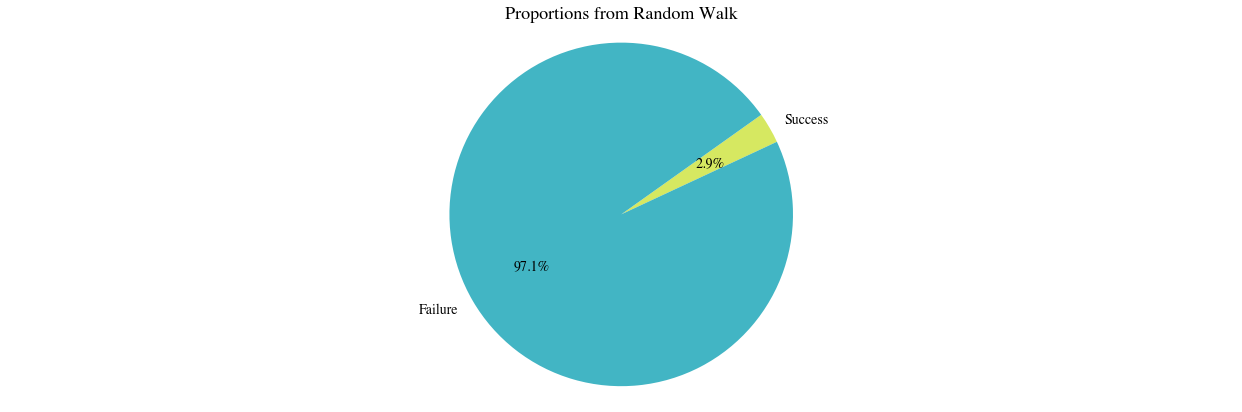

In [73]:
proportions = [n_success, n_failure]
labels = ['Success', 'Failure']
fig1, ax1 = plt.subplots()
colors = ["#d6e861", "#42b5c4"]
ax1.pie(proportions, labels = labels, autopct='%1.1f%%', shadow = False, startangle= 25, colors = colors, textprops=lfont)
ax1.axis('equal')
plt.title('Proportions from Random Walk', **tfont)
plt.savefig('random_props.png')
fig = plt.gcf()
fig.set_size_inches(22,7)
plt.show()

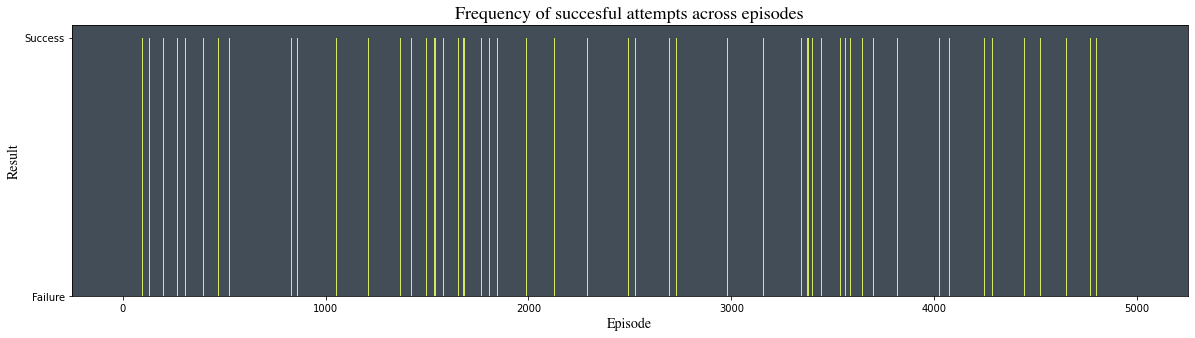

In [74]:
plt.figure(figsize=(20, 5))
plt.xlabel("Episode", **lfont)
plt.ylabel("Result", **lfont)
ax = plt.gca()
ax.set_facecolor('#424d57')
plt.bar(range(len(outcomes)), outcomes, color="#d6e861", width=2.0)
plt.savefig('random_freqs.png')
plt.title('Frequency of succesful attempts across episodes', **hfont)
plt.show()

## Policy iteration

<center>
    <img src="policy_iteration_def.png" width=500 height=500 />
</center>

In [7]:
def policy_iteration(environment, policy_eval_iterations, max_iterations,  discount, epsilon):
    
    value_function = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)
    
    for iteration in range(max_iterations):
        for eval_iters in range(policy_eval_iterations):
            delta = 0
            for state in range(env.observation_space.n):
                value_function_prime = value_function[state]
                value_function[state] = q_policy(env, value_function, state, policy[state], discount)
                delta = max(delta, abs(value_function_prime-value_function[state]))
            if delta < epsilon: 
                break

        stable = True
        for state in range(env.observation_space.n):
            prev_action = policy[state]
            q_policies = []
            
            for action in range(env.action_space.n):
                q_policies.append(q_policy(env, value_function, state, action, discount))
                a
            policy[state] = np.argmax(q_policies)
            
            if prev_action != policy[state]:
                stable = False
                
        if stable:
            break
            
    return value_function, policy

In [8]:
def q_policy(env, value_function, state, action, discount):
    initial_value = 0
    for prob, state, reward, final in env.P[state][action]:
        initial_value += prob*(reward + discount*value_function[state])
    return initial_value

In [9]:
V, pi = policy_iteration(env, policy_eval_iterations=500,  max_iterations= 500, discount=0.95, epsilon=1e-4)

<center>
    <img src="attempt1.png" width=250 height=250 />
</center>

In [10]:
a2w = {0:'<', 1:'v', 2:'>', 3:'^'}
policy_arrows = np.array([a2w[x] for x in pi])
print(np.array(policy_arrows).reshape([-1, 4]))

[['^' '^' '^' '>']
 ['<' '<' '<' '>']
 ['<' '<' '<' '>']
 ['<' '<' '<' '<']]


In [11]:
def render_single(env, policy, max_steps=100):
    episode_reward = 0
    ob, prob = env.reset()
    for t in range(max_steps):
        env.render()
        time.sleep(0.25)
        a = policy[ob]
        ob, rew, done, _, prob = env.step(a)
        episode_reward += rew
        if done:
            break
    env.render();
    return episode_reward


In [12]:
episodes = 100

In [47]:
succs = 0
for episode in range(episodes):
    succs += render_single(env, pi, 100)

In [49]:
pi_failures = episodes - succs

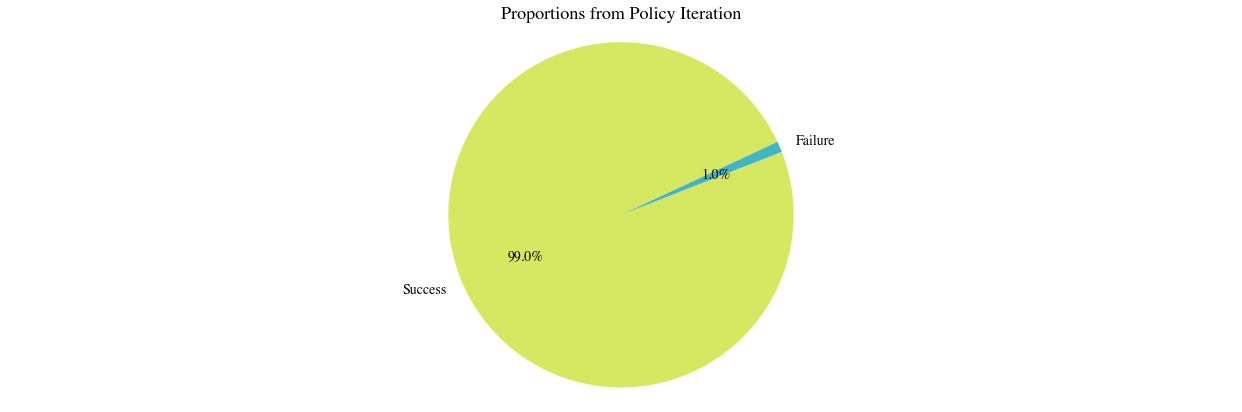

In [54]:
proportions = [succs, pi_failures]
labels = ['Success', 'Failure']
fig1, ax1 = plt.subplots()
colors = ["#d6e861", "#42b5c4"]
ax1.pie(proportions, labels = labels, autopct='%1.1f%%', shadow = False, startangle= 25, colors = colors, textprops=lfont)
ax1.axis('equal')
plt.title('Proportions from Policy Iteration', **tfont)
plt.savefig('policy_iter_props.png')
fig = plt.gcf()
fig.set_size_inches(22,7)
plt.show()

## Value iteration

<center>
    <img src="value_iteration_def.png" width=500 height=500 />
</center>

In [14]:
def value_iteration(P, states, actions, discount=0.95, epsilon=1e-3, max_iter = 1000):
    value_f = np.zeros(states)
    val_f_prime = np.copy(value_f)
    
    for iteration in range(max_iter):
        for state in range(states):
            action_values = []
            for action in range(actions):
                current_state_value = 0
                for i in range(len(P[state][action])):
                    probability, nextstate, reward, terminal = P[state][action][i]
                    state_action_value = probability * (reward + discount*value_f[nextstate])
                    current_state_value += state_action_value
                action_values.append(current_state_value)
                best_action = np.argmax(np.asarray(action_values))
                val_f_prime[state] = action_values[best_action]
        if iteration > 1000:
            if sum(value_f) - sum(val_f_prime) < epsilon:
                break
                print(i)
        else:
            value_f = val_f_prime.copy()
    
    return value_f    

In [15]:
def value_iteration_policy(P, states, actions, state_value, discount=0.9):
    policy = np.zeros(states, dtype=int)
    for state in range(states):
        action_values = []
        for action in range(actions):
            action_value = 0
            for i in range(len(P[state][action])):
                probability, nextstate, reward, terminal = P[state][action][i]
                action_value += probability * (reward + discount * state_value[nextstate])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy

In [16]:
V_vi = value_iteration(env.P, env.observation_space.n, env.action_space.n, discount=0.9, epsilon=1e-3)

In [17]:
policy = value_iteration_policy(env.P, env.observation_space.n, env.action_space.n, V_vi)

In [18]:
episodes = 100

In [21]:
vi_success = 0
for episode in tqdm.tqdm(range(episodes)):
    vi_success += render_single(env, pi, 100)
vi_failures = episodes - vi_success

100%|██████████| 100/100 [31:17<00:00, 18.77s/it]


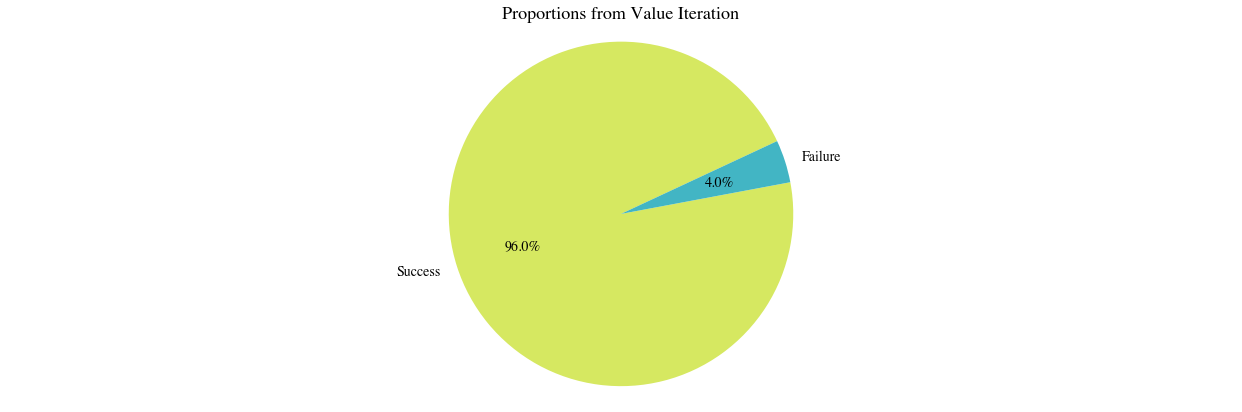

In [24]:
proportions = [vi_success, vi_failures]
labels = ['Success', 'Failure']
fig1, ax1 = plt.subplots()
colors = ["#d6e861", "#42b5c4"]
ax1.pie(proportions, labels = labels, autopct='%1.1f%%', shadow = False, startangle= 25, colors = colors, textprops=lfont)
ax1.axis('equal')
plt.title('Proportions from Value Iteration', **tfont)
plt.savefig('value_iter_props.png')
fig = plt.gcf()
fig.set_size_inches(22,7)
plt.show()